## Import libraries

In [1]:
import pandas as pd
import numpy as np
import feather

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor

## Reading data

In [4]:
dataset = pd.read_csv('../data/FinalDataset.csv')

In [3]:
dataset.head(10)

age  user_id            region_name             city_name  \
0  31.0   350459  Удмуртская Республика                Ижевск   
1  35.0   188276  Ленинградская область                 Тосно   
2  41.0    99002     Пензенская область              Заречный   
3  33.0   155506     Краснодарский край             Краснодар   
4  54.0   213873     Краснодарский край             Краснодар   
5  63.0   212300     Краснодарский край               Армавир   
6  33.0   268755        Санкт-Петербург       Санкт-Петербург   
7  39.0   350740      Рязанская область                Рязань   
8  27.0   357123         Алтайский край               Барнаул   
9  66.0   113057       Хабаровский край  Комсомольск-на-Амуре   

  cpe_manufacturer_name       cpe_model_name cpe_type_cd cpe_model_os_type  \
0                Xiaomi         Redmi Note 7  smartphone           Android   
1               Samsung  Galaxy A8 2018 Dual  smartphone           Android   
2                Huawei             Honor 8X  smartphone           Android   
3                 Apple        iPhone 7 Plus  smartphone               iOS   
4                Huawei             Honor 6A  smartphone           Android   
5               Samsung        Galaxy S20 FE  smartphone           Android   
6                 Apple             iPhone 7  smartphone               iOS   
7                 Apple             iPhone 6  smartphone               iOS   
8               Samsung       Galaxy A32 LTE  smartphone           Android   
9               Samsung           Galaxy A31  smartphone           Android   

     price  count  Sum_req PartofDay  
0  14948.0    178      240       day  
1  11434.0    111      157   evening  
2  18288.0    639      856       day  
3  37090.0     22       38   morning  
4   8987.0      4        4   morning  
5  41990.0   2628     4571   evening  
6  36706.0   1394     2381       day  
7  20990.0    144      172       day  
8  21029.0     13       14       day  
9  17579.0     89      126       day

## Data preprocessing

In [4]:
def full_nan_value(dataset):
    return dataset.fillna(0)

def convert_value_to_int(dataset):
    return dataset.astype(int)

def removing_unnecessary_columns(dataset):
    dataset.drop(['city_name', 'cpe_model_os_type', 'cpe_model_name',
                  'region_name', 'cpe_manufacturer_name', 'cpe_type_cd', 'PartofDay'], axis=1, inplace=True)
    return dataset

def concert_categorical_data(dataset):
    categorical_features = ['region_name', 'cpe_manufacturer_name', 'cpe_type_cd', 'PartofDay']
    encoder = joblib.load('./onehot_encoder_model.joblib')
    encoded_data = encoder.transform(dataset[categorical_features])
    encoded_data = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_features))
    dataset = pd.concat([dataset, encoded_data], axis=1)
    return dataset


In [5]:
dataset = (dataset.pipe(full_nan_value)
                    .pipe(concert_categorical_data)
                    .pipe(removing_unnecessary_columns)
                    .pipe(convert_value_to_int))

In [6]:
dataset

age  user_id  price  count  Sum_req  region_name_Алтайский край  \
0        31   350459  14948    178      240                           0   
1        35   188276  11434    111      157                           0   
2        41    99002  18288    639      856                           0   
3        33   155506  37090     22       38                           0   
4        54   213873   8987      4        4                           0   
...     ...      ...    ...    ...      ...                         ...   
128139   31   366609  55832    266      457                           0   
128140   21   403108  83434    770     1221                           0   
128141   22    60635  61882    238      492                           0   
128142   42    72863  64951   1815     4044                           0   
128143   56   400822  14943    301      485                           0   

        region_name_Амурская область  region_name_Архангельская область  \
0                                  0                                  0   
1                                  0                                  0   
2                                  0                                  0   
3                                  0                                  0   
4                                  0                                  0   
...                              ...                                ...   
128139                             0                                  0   
128140                             0                                  0   
128141                             0                                  0   
128142                             0                                  0   
128143                             0                                  0   

        region_name_Астраханская область  region_name_Белгородская область  \
0                                      0                                 0   
1                                      0                                 0   
2                                      0                                 0   
3                                      0                                 0   
4                                      0                                 0   
...                                  ...                               ...   
128139                                 0                                 0   
128140                                 0                                 0   
128141                                 0                                 0   
128142                                 0                                 0   
128143                                 0                                 0   

        ...  cpe_manufacturer_name_Yandex LLC  cpe_manufacturer_name_ZTE  \
0       ...                                 0                          0   
1       ...                                 0                          0   
2       ...                                 0                          0   
3       ...                                 0                          0   
4       ...                                 0                          0   
...     ...                               ...                        ...   
128139  ...                                 0                          0   
128140  ...                                 0                          0   
128141  ...                                 0                          0   
128142  ...                                 0                          0   
128143  ...                                 0                          0   

        cpe_type_cd_phablet  cpe_type_cd_plain  cpe_type_cd_smartphone  \
0                         0                  0                       1   
1                         0                  0                       1   
2                         0                  0                       1   
3                         0                  0              

## Correlation

In [7]:
target_feature = 'age'
correlation = dataset.corrwith(dataset[target_feature])

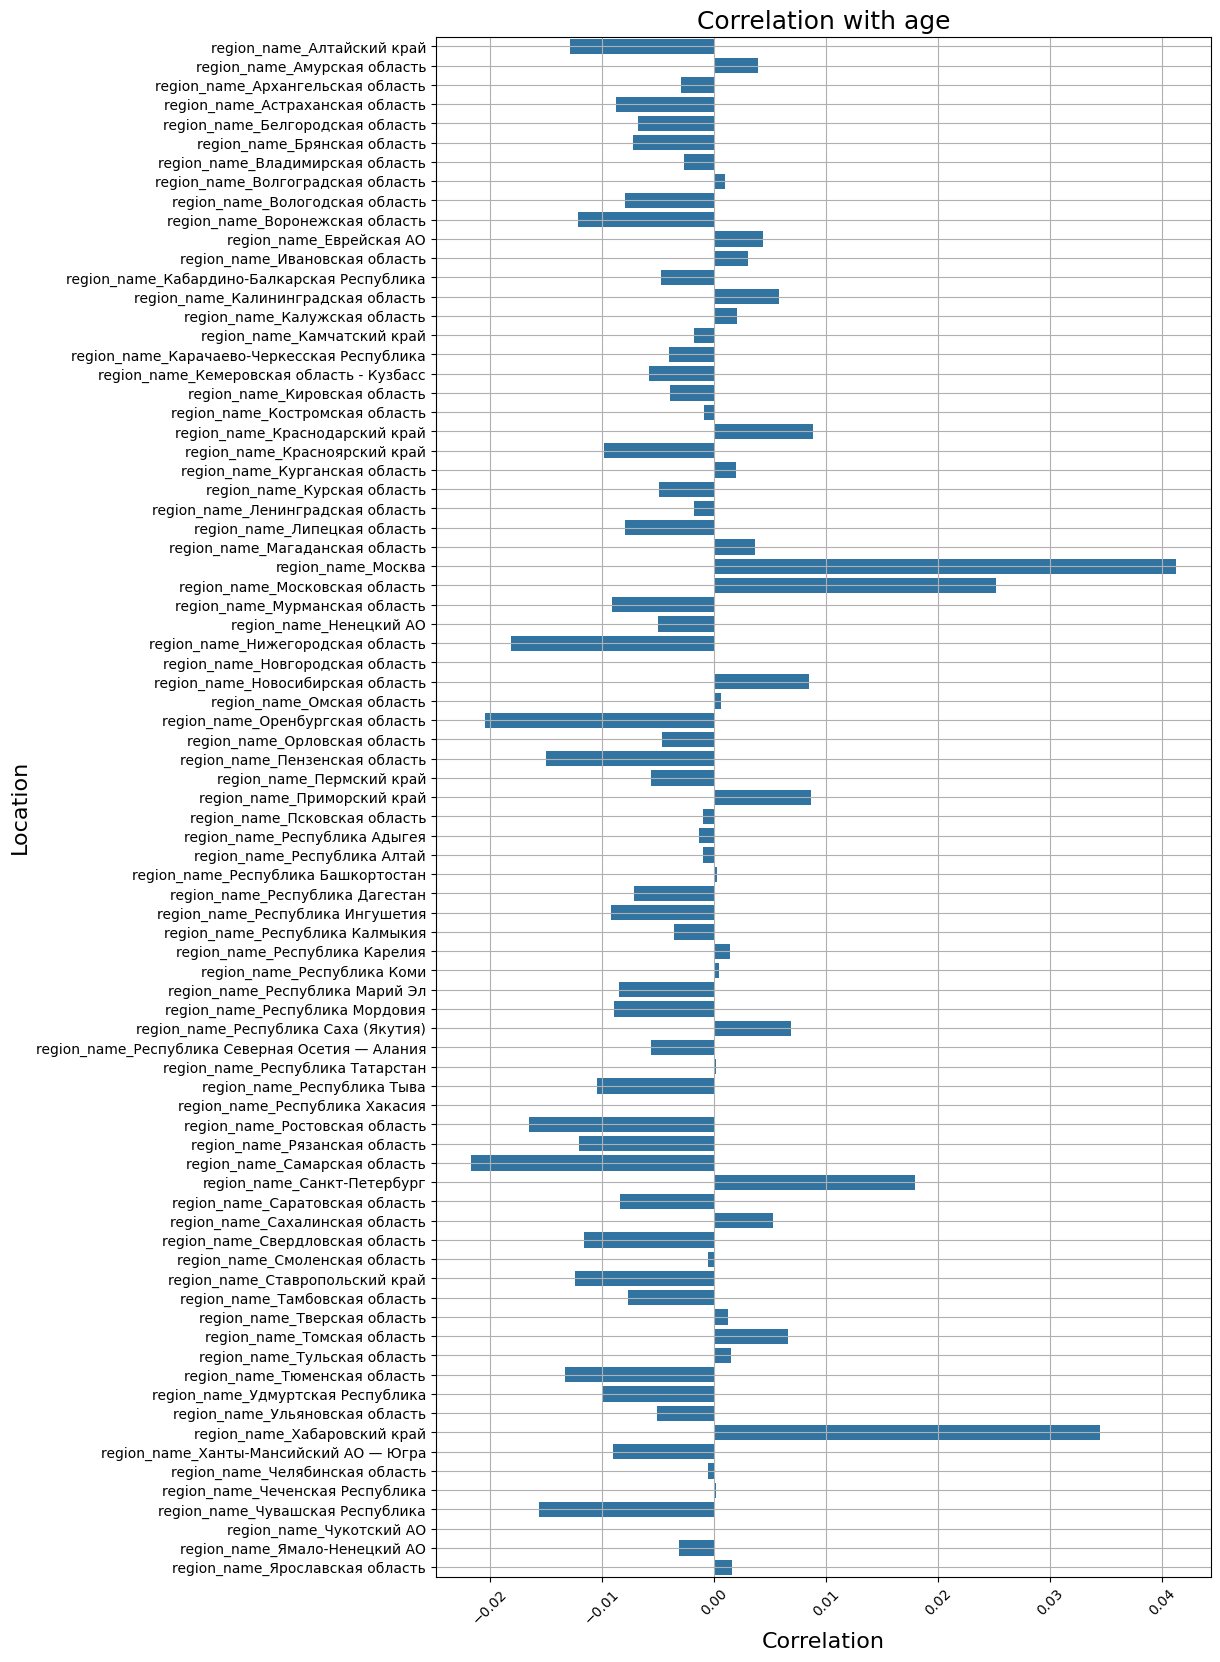

In [8]:
correlation_1group = correlation[5:85]
plt.figure(figsize=(10, 20))
sns.barplot(x=correlation_1group.values, y=correlation_1group.index)
plt.title(f'Correlation with {target_feature}',fontsize=18)
plt.xlabel('Correlation', fontsize=16)
plt.ylabel('Location', fontsize=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

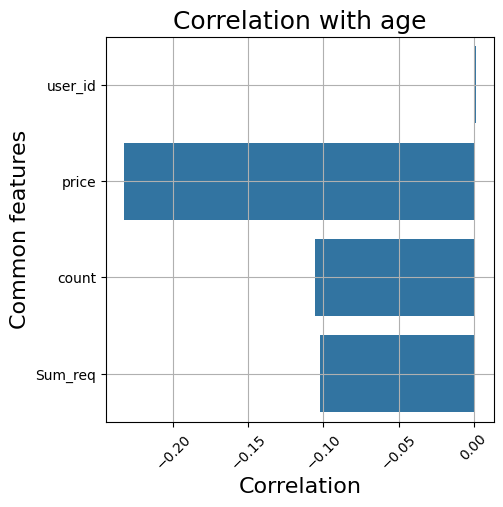

In [9]:
correlation_2group = correlation[1:5]
plt.figure(figsize=(5, 5))
sns.barplot(x=correlation_2group.values, y=correlation_2group.index)
plt.title(f'Correlation with {target_feature}', fontsize=18)
plt.xlabel('Correlation', fontsize=16)
plt.ylabel('Сommon features', fontsize=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

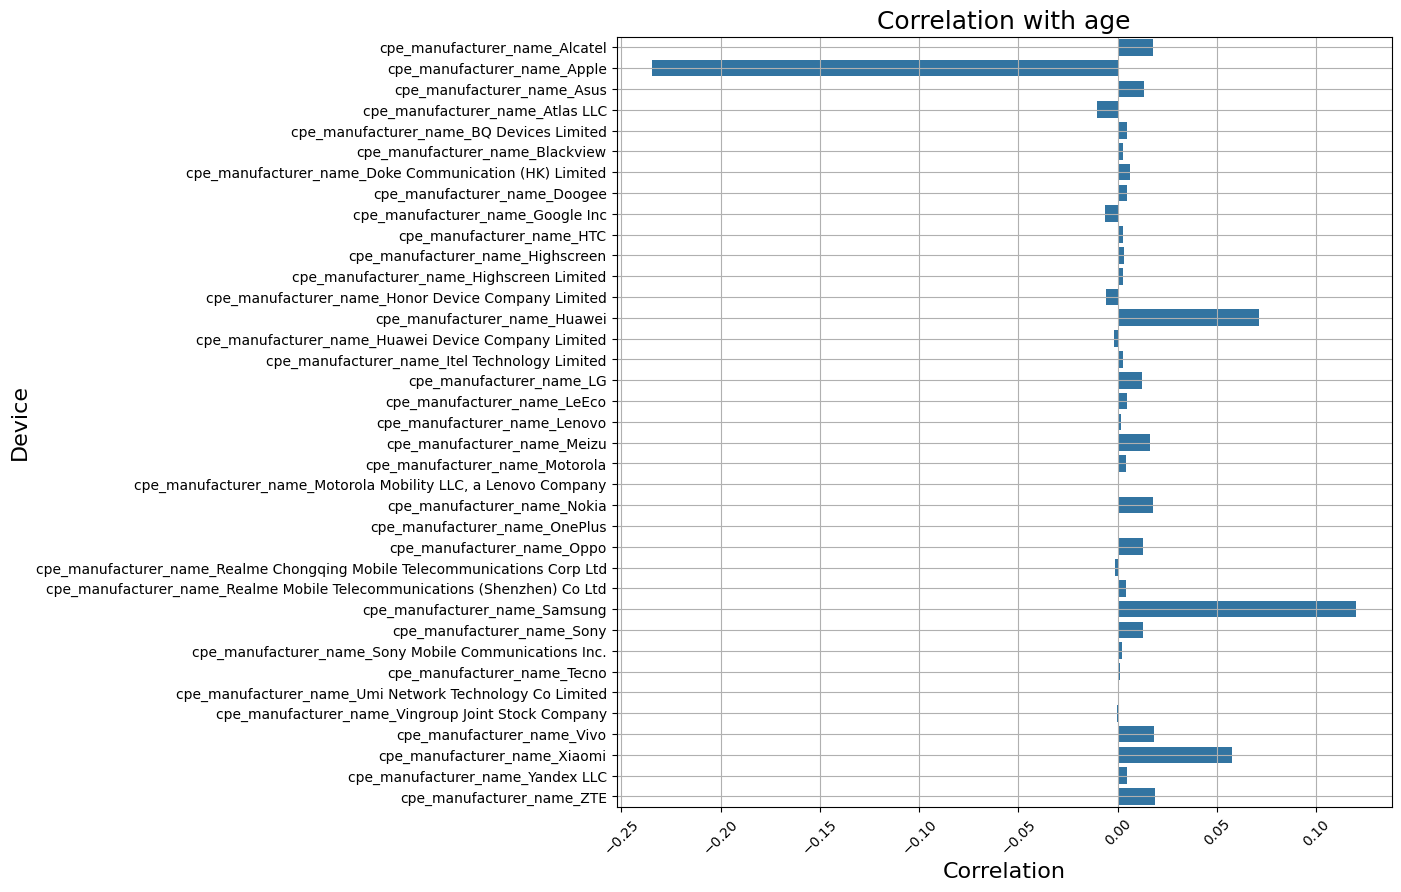

In [10]:
correlation_2group = correlation[85:122]
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_2group.values, y=correlation_2group.index)
plt.title(f'Correlation with {target_feature}', fontsize=18)
plt.xlabel('Correlation', fontsize=16)
plt.ylabel('Device', fontsize=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

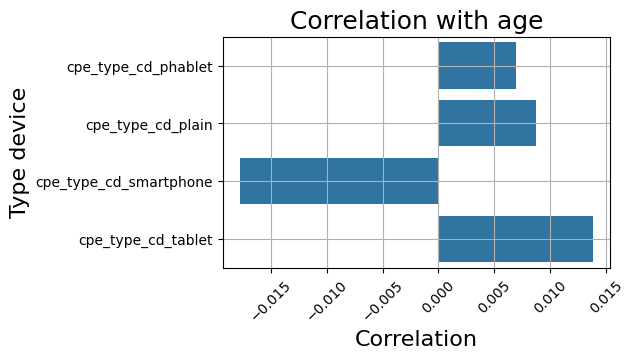

In [11]:
correlation_3group = correlation[122:126]
plt.figure(figsize=(5, 3))
sns.barplot(x=correlation_3group.values, y=correlation_3group.index)
plt.title(f'Correlation with {target_feature}',fontsize=18)
plt.xlabel('Correlation',fontsize=16)
plt.ylabel('Type device',fontsize=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

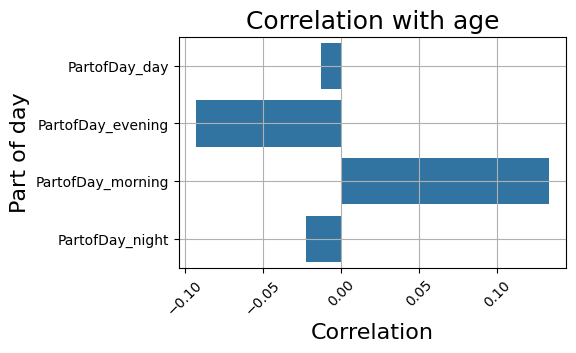

In [12]:
correlation_3group = correlation[126:130]
plt.figure(figsize=(5, 3))
sns.barplot(x=correlation_3group.values, y=correlation_3group.index)
plt.title(f'Correlation with {target_feature}', fontsize=18)
plt.xlabel('Correlation', fontsize=16)
plt.ylabel('Part of day', fontsize=16)
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Geography analysis

In [13]:
location = dataset.columns[5:85]

In [14]:
# How many registered users are there in each region
population_location = {}
for column in location:
    population_location[column] = sum(dataset[column])

population_location = dict(sorted(population_location.items(), key=lambda item: item[1], reverse=True))

print(population_location)

{'region_name_Москва': 14311, 'region_name_Краснодарский край': 14081, 'region_name_Санкт-Петербург': 7407, 'region_name_Московская область': 7036, 'region_name_Республика Башкортостан': 6976, 'region_name_Республика Татарстан': 5304, 'region_name_Свердловская область': 4425, 'region_name_Новосибирская область': 3829, 'region_name_Ростовская область': 3715, 'region_name_Самарская область': 3352, 'region_name_Челябинская область': 2661, 'region_name_Хабаровский край': 2601, 'region_name_Тюменская область': 2555, 'region_name_Пермский край': 2271, 'region_name_Ханты-Мансийский АО — Югра': 2097, 'region_name_Нижегородская область': 2080, 'region_name_Красноярский край': 2023, 'region_name_Удмуртская Республика': 1967, 'region_name_Ставропольский край': 1745, 'region_name_Приморский край': 1643, 'region_name_Оренбургская область': 1529, 'region_name_Алтайский край': 1474, 'region_name_Саратовская область': 1443, 'region_name_Ленинградская область': 1246, 'region_name_Воронежская область': 

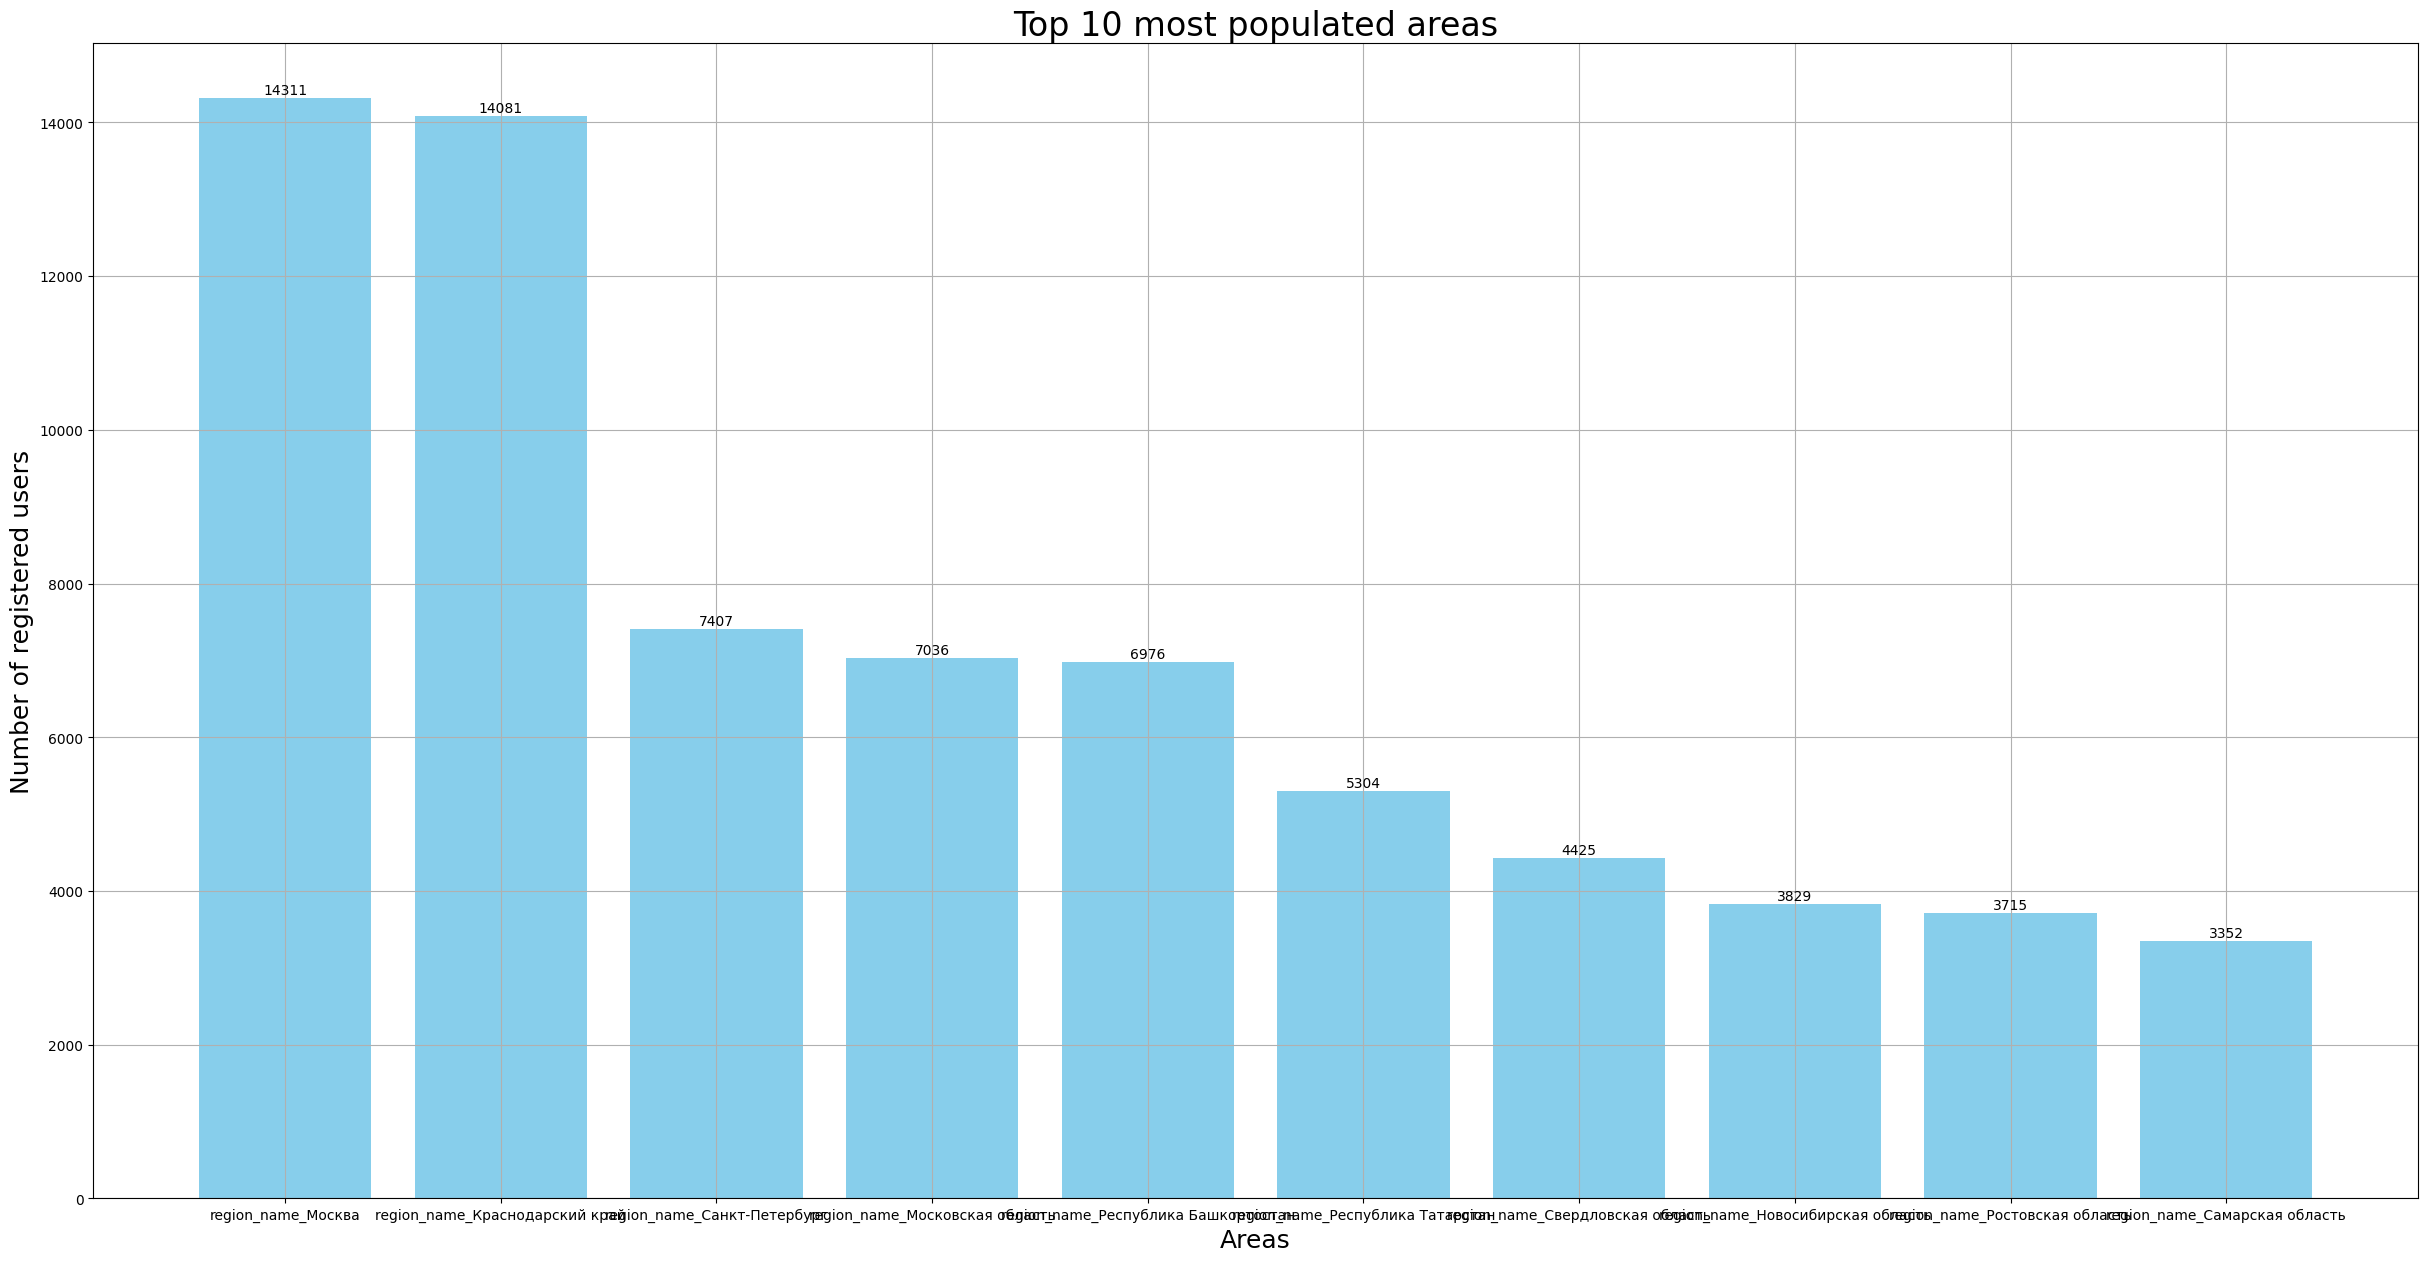

In [15]:
plt.figure(figsize=(30, 15))
plt.bar(list(population_location.keys())[:10], list(population_location.values())[:10], color='skyblue')


for i, value in enumerate(list(population_location.values())[:10]):
    plt.text(i, value + 50, str(value), ha='center')


plt.title('Top 10 most populated areas',fontsize=24)
plt.xlabel('Areas', fontsize=18)
plt.ylabel('Number of registered users', fontsize=18)


plt.grid()
plt.show()

In [16]:
# Which age is most common in each region
popular_age_location = {}
for column in location:
    df = dataset[dataset[column] == 1]
    df = df.drop_duplicates(subset='user_id', keep='first')
    if len(df) == 0:
        continue
    else:
        counts = df['age'].value_counts()
        popular_age_location[column] = counts.index[0]

popular_age_location = dict(sorted(popular_age_location.items(), key=lambda item: item[1], reverse=False))
   

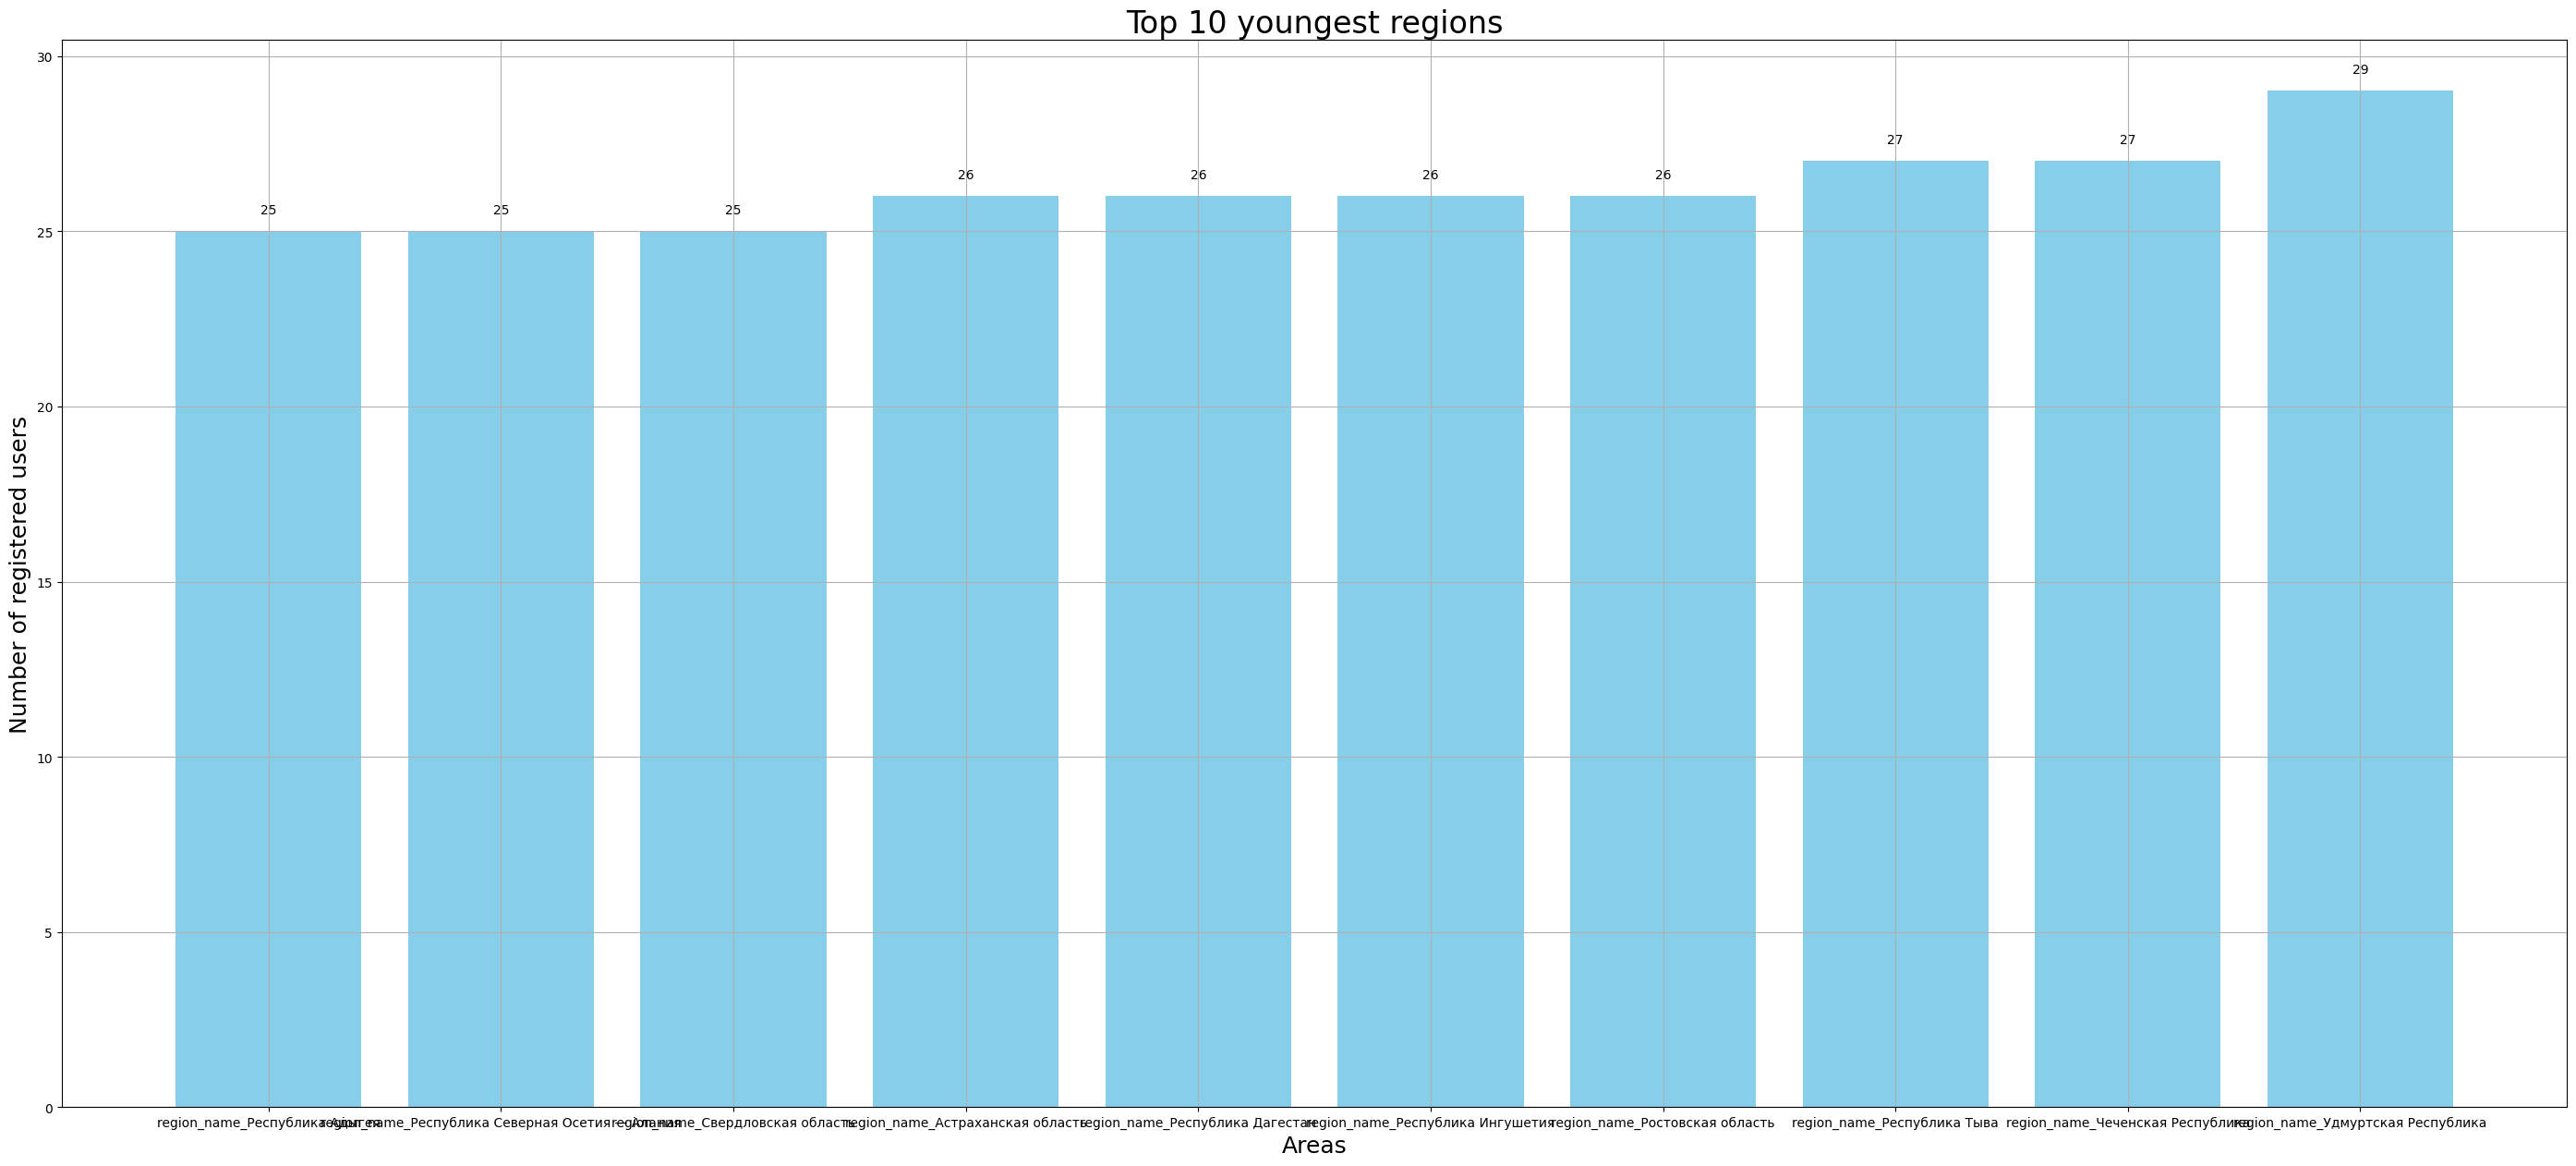

In [17]:
plt.figure(figsize=(35, 15))
plt.bar(list(popular_age_location.keys())[:10], list(popular_age_location.values())[:10], color='skyblue')


for i, value in enumerate(list(popular_age_location.values())[:10]):
    plt.text(i, value + 0.5, str(value), ha='center')


plt.title('Top 10 youngest regions',fontsize=24)
plt.xlabel('Areas', fontsize=18)
plt.ylabel('Number of registered users', fontsize=18)


plt.grid()
plt.show()

## Device Analysis

In [18]:
device = dataset.columns[85:122]

In [19]:
numbers_device = {}
for column in device:
    numbers_device[column] = sum(dataset[column])


numbers_device = dict(sorted(numbers_device.items(), key=lambda item: item[1], reverse=True))

print(numbers_device)

{'cpe_manufacturer_name_Apple': 41218, 'cpe_manufacturer_name_Samsung': 35511, 'cpe_manufacturer_name_Huawei': 27844, 'cpe_manufacturer_name_Xiaomi': 19380, 'cpe_manufacturer_name_Realme Chongqing Mobile Telecommunications Corp Ltd': 768, 'cpe_manufacturer_name_Oppo': 726, 'cpe_manufacturer_name_Huawei Device Company Limited': 584, 'cpe_manufacturer_name_Vivo': 569, 'cpe_manufacturer_name_ZTE': 280, 'cpe_manufacturer_name_Asus': 247, 'cpe_manufacturer_name_Nokia': 244, 'cpe_manufacturer_name_Sony': 152, 'cpe_manufacturer_name_Meizu': 113, 'cpe_manufacturer_name_OnePlus': 101, 'cpe_manufacturer_name_Alcatel': 63, 'cpe_manufacturer_name_Honor Device Company Limited': 59, 'cpe_manufacturer_name_LG': 53, 'cpe_manufacturer_name_Sony Mobile Communications Inc.': 36, 'cpe_manufacturer_name_BQ Devices Limited': 34, 'cpe_manufacturer_name_LeEco': 29, 'cpe_manufacturer_name_Doke Communication (HK) Limited': 21, 'cpe_manufacturer_name_Tecno': 21, 'cpe_manufacturer_name_Google Inc': 16, 'cpe_manuf

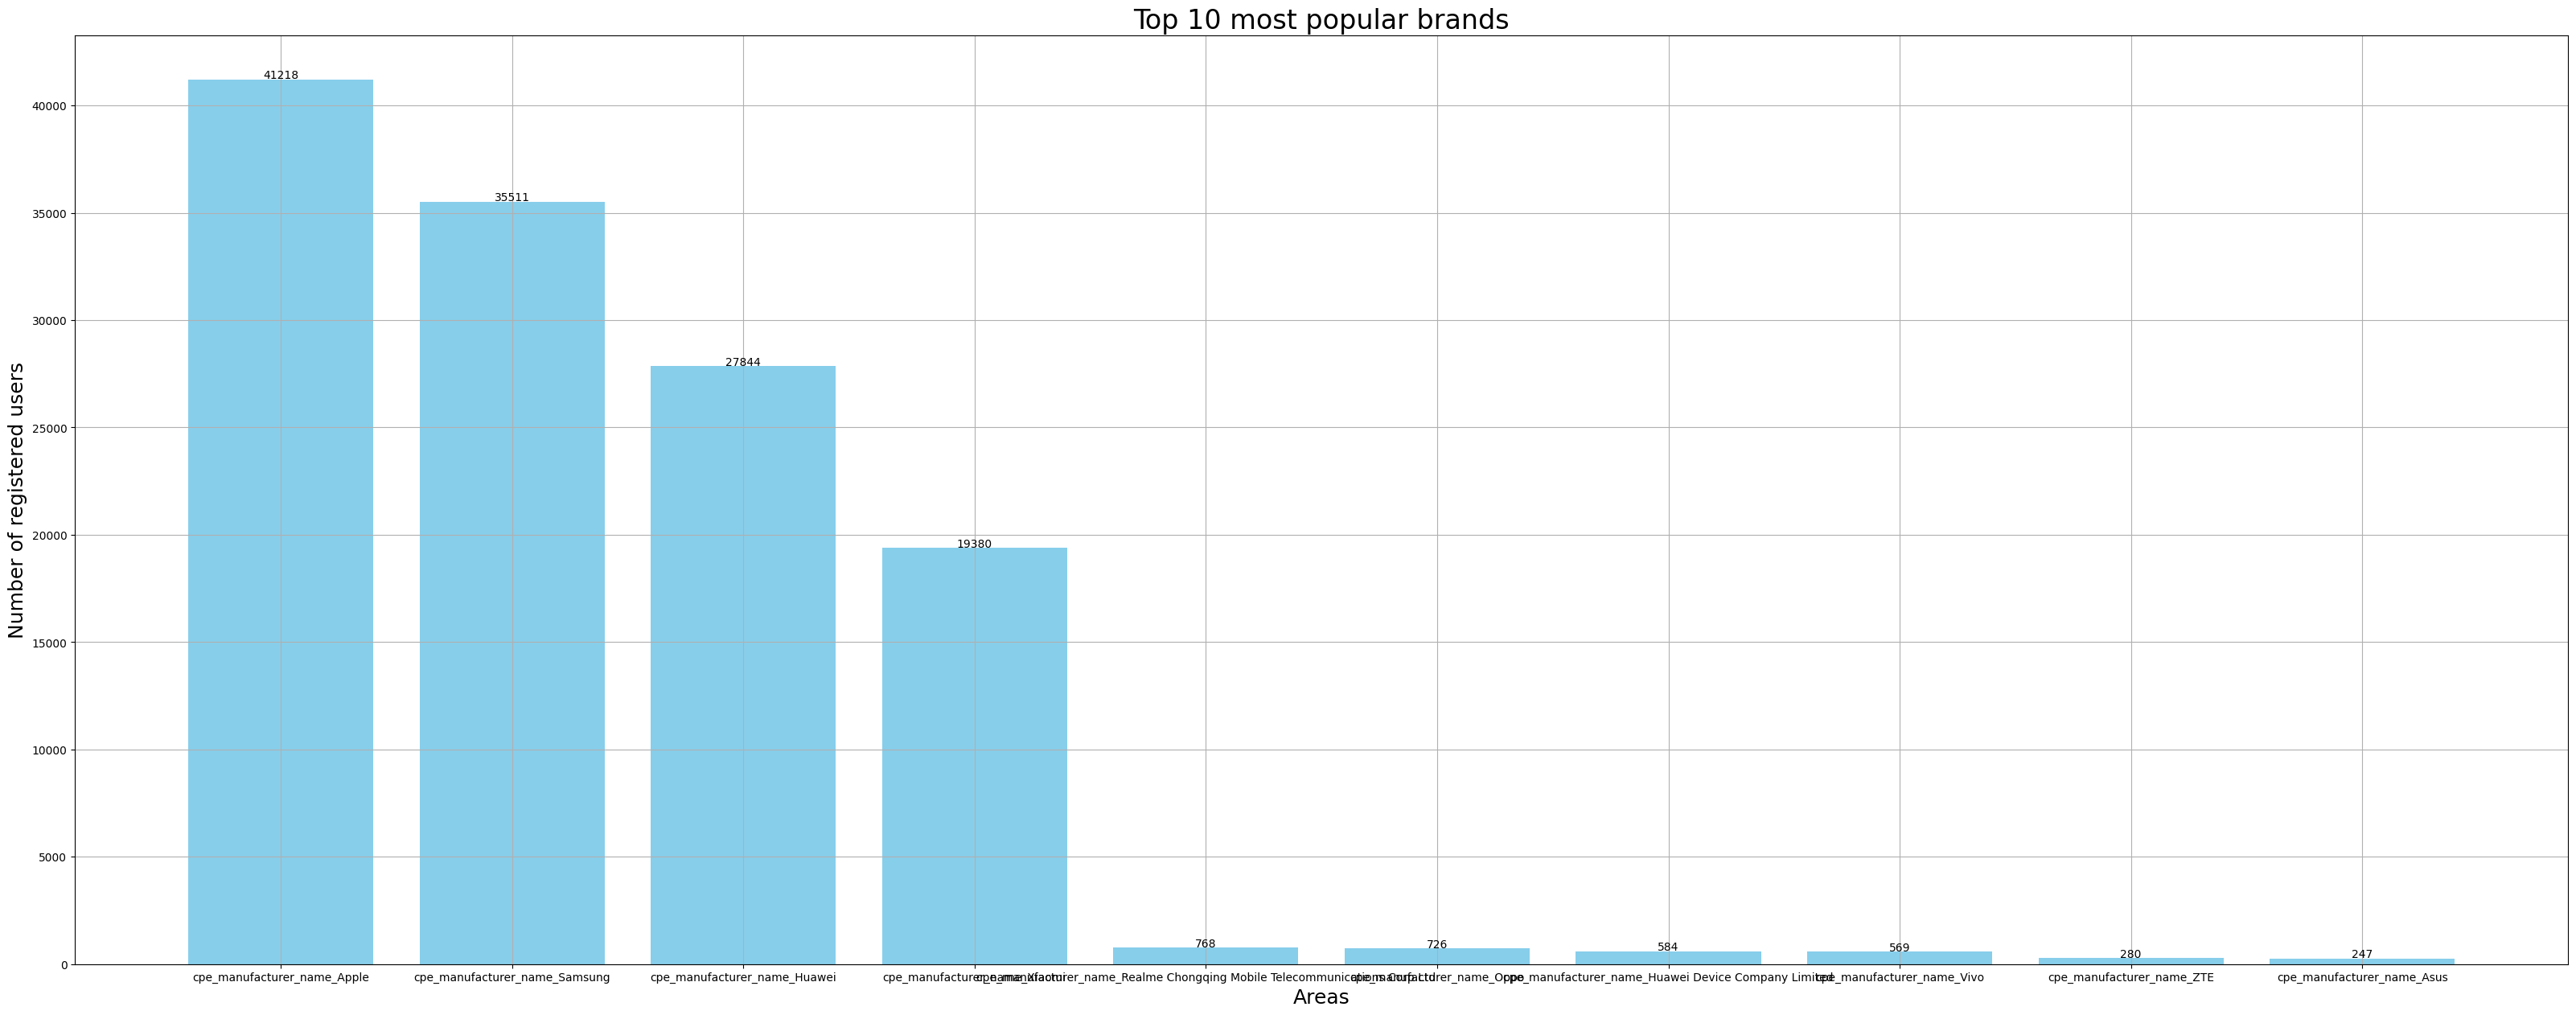

In [20]:
plt.figure(figsize=(40, 15))
plt.bar(list(numbers_device.keys())[:10], list(numbers_device.values())[:10], color='skyblue')


for i, value in enumerate(list(numbers_device.values())[:10]):
    plt.text(i, value + 50, str(value), ha='center')

plt.title('Top 10 most popular brands',fontsize=24)
plt.xlabel('Areas', fontsize=18)
plt.ylabel('Number of registered users', fontsize=18)

plt.grid()
plt.show()

# Regression

In [21]:
X = dataset.drop(columns=['age'])  
y = dataset['age'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = CatBoostRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [300, 500, 700],  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

print("Наилучшие параметры:", grid_search.best_params_)
print("Наилучший результат:", grid_search.best_score_)

0:	learn: 11.7187613	total: 75.2ms	remaining: 22.5s
1:	learn: 11.7089822	total: 82.4ms	remaining: 12.3s
2:	learn: 11.6995102	total: 85.2ms	remaining: 8.43s
3:	learn: 11.6901862	total: 87.8ms	remaining: 6.5s
4:	learn: 11.6809288	total: 90.4ms	remaining: 5.33s
5:	learn: 11.6717669	total: 93.5ms	remaining: 4.58s
0:	learn: 11.6922526	total: 65ms	remaining: 19.4s
6:	learn: 11.6631449	total: 97.6ms	remaining: 4.09s
1:	learn: 11.6826664	total: 68.3ms	remaining: 10.2s
7:	learn: 11.6545816	total: 102ms	remaining: 3.72s
2:	learn: 11.6734212	total: 75.3ms	remaining: 7.45s
0:	learn: 11.6984516	total: 67.7ms	remaining: 20.2s
0:	learn: 11.6779680	total: 65.8ms	remaining: 19.7s
8:	learn: 11.6461341	total: 111ms	remaining: 3.6s
1:	learn: 11.6887227	total: 73.8ms	remaining: 11s
0:	learn: 11.6540885	total: 72.1ms	remaining: 21.6s
3:	learn: 11.6641594	total: 83.9ms	remaining: 6.21s
1:	learn: 11.6339167	total: 73.4ms	remaining: 10.9s
2:	learn: 11.6791266	total: 79ms	remaining: 7.82s
4:	learn: 11.6552509	t

In [25]:
model = CatBoostRegressor(iterations=700, depth=6, learning_rate=0.05, loss_function='RMSE', random_seed=42)
model.fit(X_train, y_train, verbose=100)  # verbose controls the level of logging during training

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

0:	learn: 11.6774020	total: 3.55ms	remaining: 2.48s
100:	learn: 11.0374249	total: 321ms	remaining: 1.91s
200:	learn: 10.9975393	total: 626ms	remaining: 1.55s
300:	learn: 10.9568797	total: 933ms	remaining: 1.24s
400:	learn: 10.9203948	total: 1.24s	remaining: 926ms
500:	learn: 10.8893404	total: 1.55s	remaining: 615ms
600:	learn: 10.8590034	total: 1.86s	remaining: 306ms
699:	learn: 10.8327339	total: 2.16s	remaining: 0us
Mean Squared Error: 119.02613509501515
Mean Absolute Error: 8.780431071582662
R-squared: 0.12500844993764804


In [26]:
model.save_model('catboost_model.cbm')